# 필요한 라이브러리 및 모듈

In [1]:
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models import doc2vec
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import ast
import numpy as np
import math
from time import time
from tqdm import tqdm
from collections import namedtuple
from gensim.models import Word2Vec, Doc2Vec
        
def rm_whitespace(x):
    result = []
    for i in x:
        if i != '':
            result.append(i)
        else:
            pass
    return result
    
# evaluation metrices: Precision, Recall, NDCG@K
def compute_metrics(pred_u, target_u, top_k):
    pred_k = pred_u[:top_k]
    num_target_items = len(target_u)

    hits_k = [(i + 1, item) for i, item in enumerate(pred_k) if item in target_u]
    # print("실제로 맞춘 items (position, idx):", hits_k)
    num_hits = len(hits_k)

    idcg_k = 0.0
    for i in range(1, min(num_target_items, top_k) + 1):
        idcg_k += 1 / math.log(i + 1, 2)

    dcg_k = 0.0
    for idx, item in hits_k:
        dcg_k += 1 / math.log(idx + 1, 2)
    
    prec_k = num_hits / top_k
    recall_k = num_hits / min(num_target_items, top_k)
    ndcg_k = dcg_k / idcg_k

    return prec_k, recall_k, ndcg_k

# 사용자가 본 영화들의 embedding의 평균 계산
def aggregate_vectors(movie_list):

    product_vec = []
    for i in movie_list:
        try:
            product_vec.append(model.docvecs[i])
            
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

# 조건 설정하는 법
    
    1. 몇 편 이상의 유저로 사용할지
        - 데이터 전처리 파트에 #### code ####와 같이 존재하는 부분으로 이동
        - 아래 코드에 존재하는 숫자가 몇 편 이상으로 할지 선정
            df_user_watch.loc[df_user_watch['cnt_watch']>=10].index
    2. train-test 분리하는 법
        - 데이터 전처리 파트에 마찬가지로 #### code ####와 같이 존재하는 부분으로 이동
        - 랜덤 버전을 할 경우 #랜덤버전 아래의 코드 한줄만 앞의 코드에 #이 없도록 실행

          train, test = train_test_split(df, test_size=0.2, stratify=df['userr'],random_state = 1234)
          #flag_range = int(df.shape[0]*80)
          #df= df.sort_values(by=['year','month','day','hour','min','sec'],ascending=True)
          #train = df[:flag_range]
          #test = df[flag_range:]

        - 기간 선택 버전을 할 경우, #시간 선택 버전 아래의 코드들만 #을 없애고 실행
          
          #train, test = train_test_split(df, test_size=0.2, stratify=df['userr'],random_state = 1234)
          flag_range = int(df.shape[0]*80)
          df= df.sort_values(by=['year','month','day','hour','min','sec'],ascending=True)
          train = df[:flag_range]
          test = df[flag_range:]   
     3. 이전에 시청한 영화를 평가에 포함할지
         - 유저 평가하기 파트에 마찬가지로 #### code ####와 같이 존재하는 부분으로 이동
         - 포함 시킬 경우, 아래와 같이 진행(진행할 코드에만 #을 제거)

            for i, _ in enumerate(sim_movies_all):
                #if sim_movies_all[i][0] not in movie_list:
                #    sim_movies.append((sim_movies_all[i][0], sim_movies_all[i][1]))
                sim_movies.append((sim_movies_all[i][0], sim_movies_all[i][1]))
            
        - 미포함 시킬 경우, 아래와 같이 진행
        
            for i, _ in enumerate(sim_movies_all):
                if sim_movies_all[i][0] not in movie_list:
                    sim_movies.append((sim_movies_all[i][0], sim_movies_all[i][1]))
                #sim_movies.append((sim_movies_all[i][0], sim_movies_all[i][1]))
                
    4. 변수 추가
        - 해당 경우는 워낙 경우의 수가 많아서 완전하게 해드릴 수는 없을 것 같구요. 기본적으로 추가하는 방법을 알려드리지만,
        오류가 나면 저한테 알려주시거나 한번 해결해보세요. 
        - 설명은 적어놓았는데 다음과 같습니다.
           
           0. 아래의 과정들을 진행했는데도 오류가 난다면, 데이터 안에 값 자체를 전처리해주어야 합니다.
                null,nan과 같은 결측값을 대체해주거나, 문자나 리스트와 같은 값들로 변경해주어야 합니다.
                df['genre'] = df['genre'].apply(lambda x: x.split("|"))
                df['genre'] = df['genre'].apply(lambda x: rm_whitespace(x))
                df['actors'] = df['actors'].fillna('없음')
                
           1. 데이터 전처리 코드 중에 수정할 곳들이 존재합니다
           2. "# n단계 조건 : 새로운 변수 추가" 라는 주석이 존재하는 곳에 갑니다
           3. "# new_feature = 'genre_people_country'#<<여기에 해당 형식으로 추가" 아래의 내용을 참고해서 코드를 완료합니다
           4. 컬럼 안에 값의 종류에 따라 각기 다른 코드를 수정해야 해서 이 부분만 주의해서 반영해주세요
            # 경우의 수 1 - 컬럼의 값이 장르처럼 리스트일 경우, ['코미디','드라마']
            # columns = x['column']#<< 여기에 추가할 컬럼명 추가
            #for column in columns:
            #    result.append(column)        

            # 경우의 수 2 - 컬럼의 값이 국가처럼 문자일 경우, '한국'
            # result.append(x['column'])#<< 여기에 추가할 컬럼명 추가

# 데이터 불러오기

In [2]:
# 데이터가 커서 길이를 설정해놓았습니다. nrows=10000 자체를 없애거나 숫자를 변경해서 데이터 크기를 조정해보세요.
df = pd.read_csv('test2.csv', nrows = 100000)
df_stopwords = pd.read_csv('data/한국어불용어100.txt',sep='\t', header=None,names=['words','b','c'])
lst_words = df_stopwords['words'].values

# 데이터 전처리

In [3]:
# 1단계 조건 : 새로운 변수 추가
def preprocessing(x, stop_words):
    okt = Okt()
    try:
        sentence_tokens = okt.nouns(x['summary'])

        result = []
        for token in sentence_tokens: 
            if token not in stop_words:
                result.append(token)
        
        genres = x['genre']
        for genre in genres:
            result.append(genre)
            
        result.append(x['country'])
        
        # 경우의 수 1 - 컬럼의 값이 장르처럼 리스트일 경우, ['코미디','드라마']
        # columns = x['column']#<< 여기에 추가할 컬럼명 추가
        #for column in columns:
        #    result.append(column)        

        # 경우의 수 2 - 컬럼의 값이 국가처럼 문자일 경우, '한국'
        # result.append(x['column'])#<< 여기에 추가할 컬럼명 추가

        return result
    except:
        return ['없음']

In [4]:
df.columns = ['userr','iitem1','ttime',
             'title','subtitle','main_genre','genre',
             'keyword','actors','country','price','summary']

In [5]:
df_user_watch=pd.DataFrame(df['userr'].value_counts())
df_user_watch.columns=['cnt_watch']
#######################################################################################################
# 학습데이터를 몇 편이상을 시청한 user로쓸지
lst_user_real = df_user_watch.loc[df_user_watch['cnt_watch']>=10].index
#######################################################################################################
df = df.loc[df['userr'].isin(lst_user_real)]

# 변수 전처리
df['genre'] = df['genre'].apply(lambda x: x.split("|"))
df['genre'] = df['genre'].apply(lambda x: rm_whitespace(x))
df['actors'] = df['actors'].fillna('없음')
df['country'] = df['country'].fillna('없음')
df['genre'] = df['genre'].fillna('없음')
df['summary'] = df['summary'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['comebine_col'] = df.apply(lambda x: preprocessing(x, lst_words), axis=1)

df['year']=df['ttime'].apply(lambda x: str(x)[:4])
df['month']=df['ttime'].apply(lambda x: str(x)[4:6])
df['day']=df['ttime'].apply(lambda x: str(x)[6:8])
df['hour']=df['ttime'].apply(lambda x: str(x)[8:10])
df['min']=df['ttime'].apply(lambda x: str(x)[10:12])
df['sec']=df['ttime'].apply(lambda x: str(x)[12:])

# 유저 아이디 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['userr'] = le.fit_transform(df['userr']).astype(str)
le = LabelEncoder()
df['iitem1'] = le.fit_transform(df['iitem1']).astype(str)

In [6]:
# movie title와 id를 매핑할 dictionary를 생성
idx2title = {}
for i, c in zip(df['iitem1'], df['title']): 
    idx2title[i] = c

# id와 movie title를 매핑할 dictionary를 생성
title2idx = {}
for i, c in zip(df['iitem1'], df['title']): 
    title2idx[c] = i
    
    
# 전체 데이터셋의 user, item 수 확인
user_list = list(df['userr'].unique())
item_list = list(df['iitem1'].unique())
num_users = len(user_list)
num_items = len(item_list)
print(f"# of users: {num_users}, # of items: {num_items}")

#######################################################################################################
#train-test 
#랜덤버전
train_df, test_df = train_test_split(df, test_size=0.2, stratify = df['userr'], random_state = 1234)
#시간 선택 버전
#flag_range = int(df.shape[0]*80)
#df= df.sort_values(by=['year','month','day','hour','min','sec'],ascending=True)
#train_df = df[:flag_range]
#test_df = df[flag_range:]
#######################################################################################################

# train set에 있는 user set
train_users = train_df['userr'].unique()
# sorting
train_users = sorted(train_users)


train = []
for user_id in train_users:
    itemset = train_df[train_df['userr'] == user_id]['iitem1'].tolist()
    train.append(itemset)
    # print(itemset)
    
# test set에서도 동일하게 구성
test_users = test_df['userr'].unique()
# sorting
test_users = sorted(test_users)

test = []
for user_id in test_users:
    itemset = test_df[test_df['userr'] == user_id]['iitem1'].tolist()
    test.append(itemset)

model = doc2vec.Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=1,    # w2v simultaneous with DBOW d2v / default 0
    window=10,        # distance between the predicted word and context words
    #size=100,        # vector size
    alpha=0.025,     # learning-rate
    seed=1234,
    min_count=5,    # ignore with freq lower
    min_alpha=0.025, # min learning-rate
    workers=4,   # multi cpu
    hs = 1,          # hierar chical softmax / default 0
    negative = 10   # negative sampling / default 5
)

# userId로 groupby해서 original_title의 unique 항목을 추출해줍니다. 
# 해당 코드를 통해서 사용자가 본 영화의 제목이 모두 저장됩니다. 

# Doc2Vec 입력형태를 맞춰줍니다. 
# TaggedDocument 형태로 ('영화 내용', '제목') 을 받습니다. 
## 이후, TaggedDocument에 모든 문서에 대해서 '영화 내용', '제목'을 넣어줍니다.

agg = train_df[['iitem1', 'comebine_col']]
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument((c), [d]) for d, c in agg[['iitem1', 'comebine_col']].values]

# 위에서 만든 tagged_train_docs으로 사전을 만들어줍니다. 
model.build_vocab(tagged_train_docs)

# 벡터 문서 학습

start = time()

for epoch in range(5):
    # Doc2Vec 학습을 진행하는데 Learning rate를 계속 감소해주면서 학습을 진행해줍니다. 
    model.train(tagged_train_docs, total_examples=model.corpus_count, epochs=10)
    model.alpha -= 0.002 # decrease the learning rate
    model.min_alpha = model.alpha # fix the learning rate, no decay

end = time()
print("During Time: {}".format(end-start))  

# of users: 1727, # of items: 719
During Time: 68.1118049621582


## 특정 유저에 대해서 평가하기

In [7]:
# user 한 명에 대한 평가
top_k = 200
user_idx = '10'

try:
    movie_list = train_df[train_df['userr']==user_idx].iitem1.values
    target_u = test_df[test_df['userr']==user_idx].iitem1.values
    avg_emb = aggregate_vectors(movie_list)
    #print(avg_emb)
    sim_movies_all = model.docvecs.most_similar(avg_emb, topn=500)
    # train에 없는 영화만 남기기
    sim_movies = []
    #############################################################################
    #테스트할때 이전에 시청한 콘텐츠는 제외하고 평가하는것과 포함하여 평가하는것
    for i, _ in enumerate(sim_movies_all):
        if sim_movies_all[i][0] not in movie_list:
            sim_movies.append((sim_movies_all[i][0], sim_movies_all[i][1]))
        #sim_movies.append((sim_movies_all[i][0], sim_movies_all[i][1]))
    #############################################################################
    # top-N movie list 반환
    pred_u = []
    for i, (idx, _) in enumerate(sim_movies):
        pred_u.append(sim_movies[i][0])

    prec, recall, ndcg = compute_metrics(pred_u, target_u, top_k)
    print(f"Precison@{top_k}: {prec:.4f}")
    print(f"Recall@{top_k}: {recall:.4f}")
    print(f"NDCG@{top_k}: {ndcg:.4f}")
except:
    print("해당 유저는 평가가 되기 어렵습니다.")


Precison@200: 0.0000
Recall@200: 0.0000
NDCG@200: 0.0000


C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  # Remove the CWD from sys.path while we load stuff.


## 전체 유저에 대해서 평가하기

In [8]:
# 전체 user에 대한 평가
top_k = 200
prec_list = []
recall_list = []
ndcg_list = []

for user_idx in train_df.userr.unique():
    try:
        movie_list = train_df[train_df['userr']==user_idx].iitem1.values
        target_u = test_df[test_df['userr']==user_idx].iitem1.values
        avg_emb = aggregate_vectors(movie_list)
        #print(avg_emb)
        sim_movies_all = model.docvecs.most_similar(avg_emb, topn=500)
        # train에 없는 영화만 남기기
        sim_movies = []
        #############################################################################
        #테스트할때 이전에 시청한 콘텐츠는 제외하고 평가하는것과 포함하여 평가하는것
        for i, _ in enumerate(sim_movies_all):
            if sim_movies_all[i][0] not in movie_list:
                sim_movies.append((sim_movies_all[i][0], sim_movies_all[i][1]))
        #sim_movies.append((sim_movies_all[i][0], sim_movies_all[i][1]))
        #############################################################################
        # top-N movie list 반환
        pred_u = []
        for i, (idx, _) in enumerate(sim_movies):
            pred_u.append(sim_movies[i][0])

        prec, recall, ndcg = compute_metrics(pred_u, target_u, top_k)
        prec_list.append(prec)
        recall_list.append(recall)
        ndcg_list.append(ndcg)
    except:
        print("해당 유저는 평가가 되기 어렵습니다.")
        prec_list.append(0)
        recall_list.append(0)
        ndcg_list.append(0)
print(f"Precision@{top_k}: {np.mean(prec_list):.4f}")
print(f"Recall@{top_k}: {np.mean(recall_list):.4f}")
print(f"NDCG@{top_k}: {np.mean(ndcg_list):.4f}")

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  del sys.path[0]


Precision@200: 0.0014
Recall@200: 0.1027
NDCG@200: 0.0592


# word2vec 시각화 

In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgunsl.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

## t-SNE로 시각화

C:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


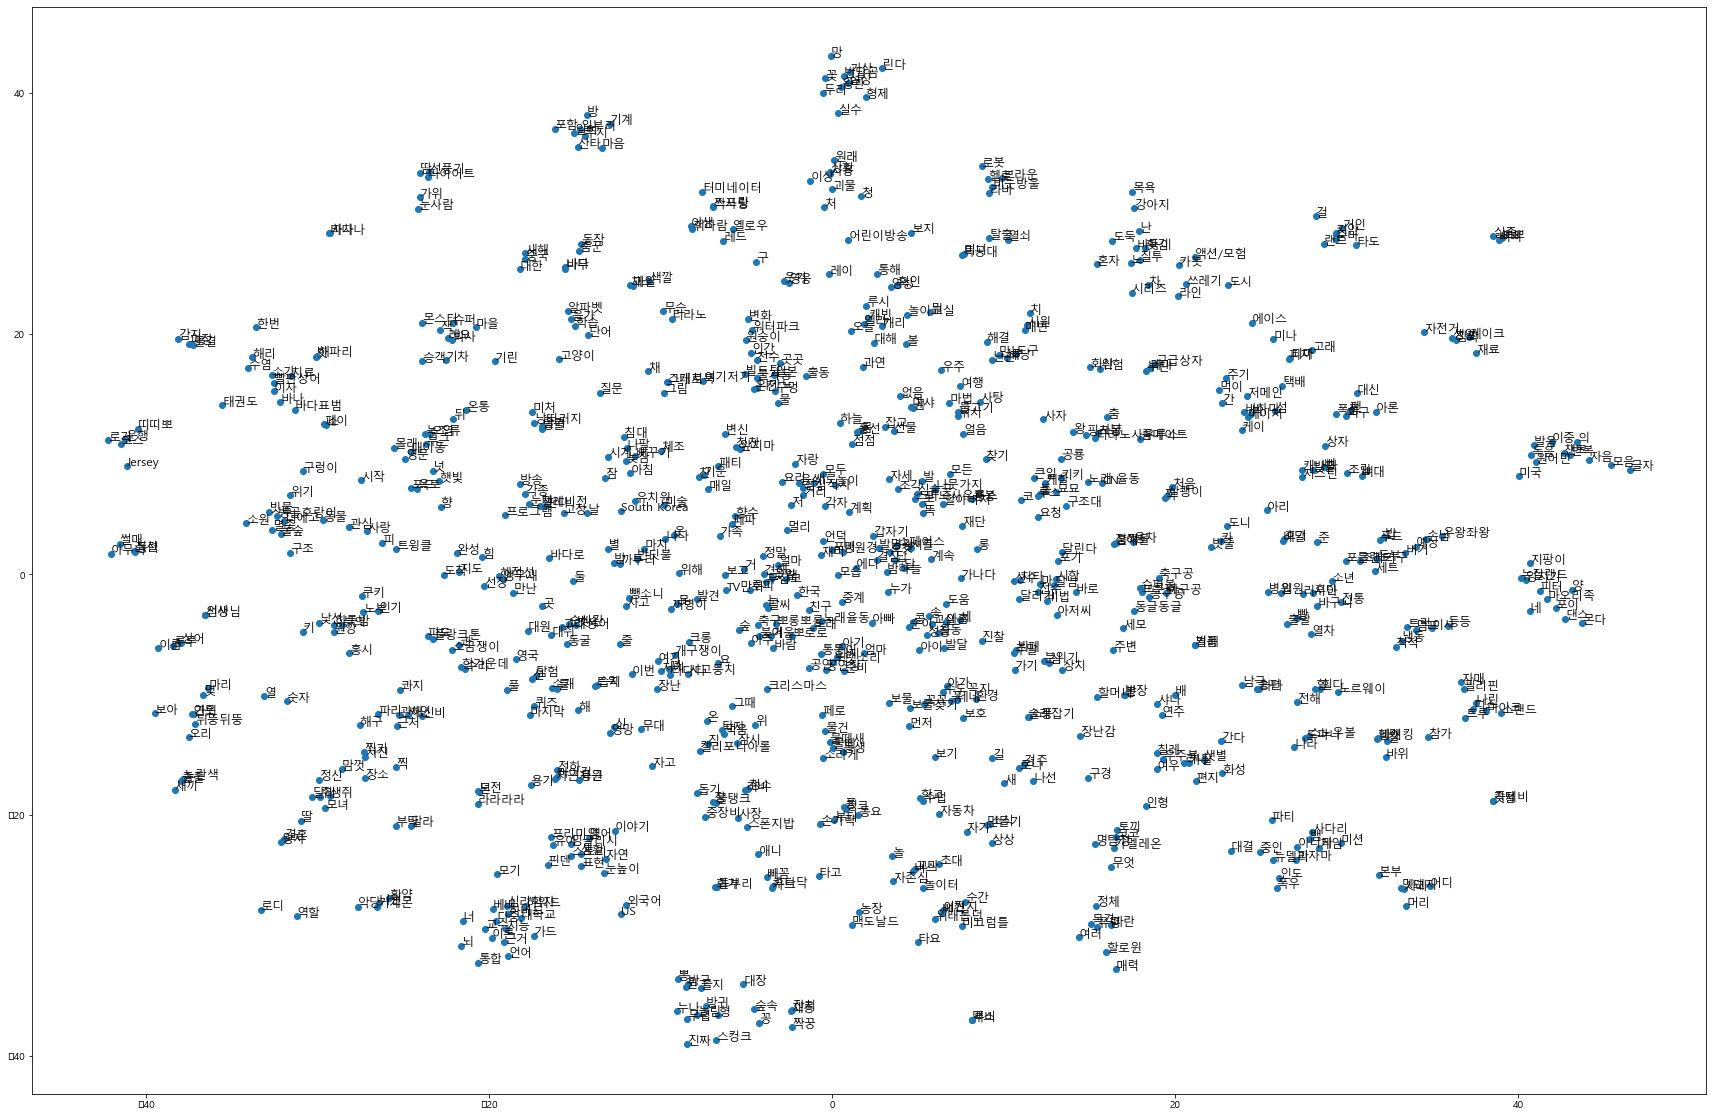

In [10]:
from gensim.models import KeyedVectors

def show_tsne(): 
    tsne = TSNE(n_components=2) 
    X = tsne.fit_transform(X_show) 
    df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y']) 
    fig = plt.figure() 
    fig.set_size_inches(30, 20) 
    ax = fig.add_subplot(1, 1, 1) 
    ax.scatter(df['x'], df['y']) 
    for word, pos in list(df.iterrows()):
        ax.annotate(word, pos, fontsize=12)
    plt.show()

        
vocab = list(model.wv.index_to_key)
X = model[vocab] # sz개의 단어에 대해서만 시각화 
sz = 800 
X_show = X[:sz,:] 
vocab_show = vocab[:sz] 
show_tsne()


## 클러스터링 시각화

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

C:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  "KMeans is known to have a memory leak on Windows "


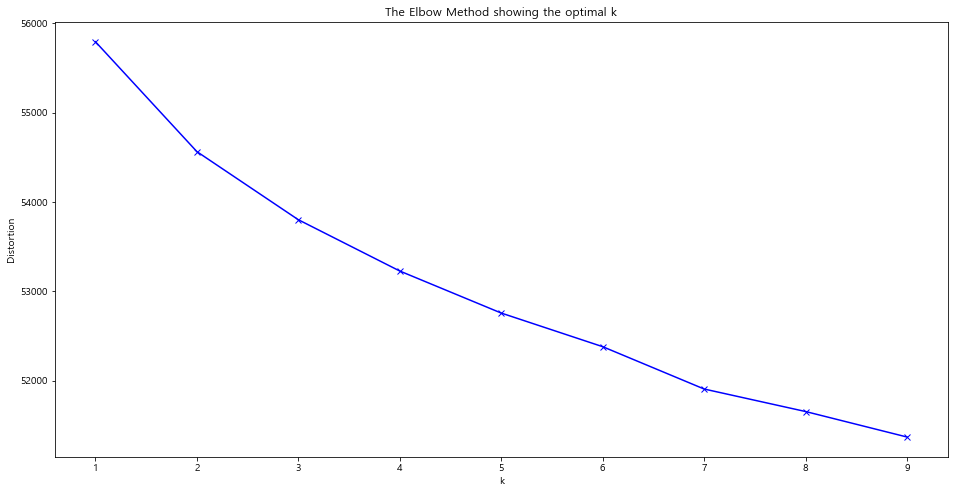

In [12]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [13]:
# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [14]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass X to the pca
pca_vecs = pca.fit_transform(X)
# save the two dimensions in x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

# assign clusters and PCA vectors to columns in the original dataframe
df_cluster_tfidf = pd.DataFrame()
df_cluster_tfidf['cluster'] = clusters
df_cluster_tfidf['x0'] = x0
df_cluster_tfidf['x1'] = x1

C:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


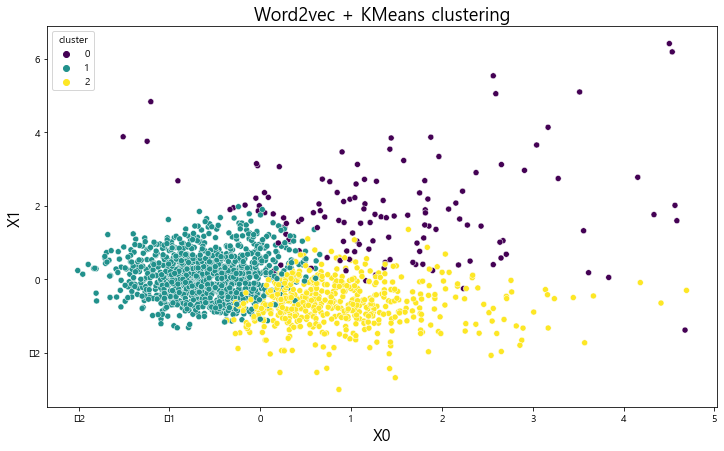

In [15]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("Word2vec + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_cluster_tfidf, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()